In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

In [2]:
point_data = pd.read_csv('Taipei_crawl_result.csv' , index_col = 0)
town_shp = gpd.read_file('TOWN_MOI_1091016.shp' , encoding='utf8')
north_town_shp = town_shp[(town_shp['COUNTYNAME'] == '臺北市') | (town_shp['COUNTYNAME'] == '新北市')]

In [3]:
# point_data中有一些不必要的column，可以直接刪除
column = '旅店當天價格'
point_data_drop = point_data.copy(deep = True)
for col in point_data_drop.columns:
    if col not in ['行政區' , '{}'.format(column)]:
        point_data_drop.drop(columns = col , inplace = True)
    
poly_data = pd.merge(left = north_town_shp ,
                     right = point_data_drop ,
                     left_on = 'TOWNNAME' ,
                     right_on = '行政區' ,
                     how = 'outer')
poly_data['{}'.format(column)].fillna(value = 0 , inplace = True)
poly_data = gpd.GeoDataFrame(poly_data)
poly_data.reset_index(inplace = True , drop = True)

In [4]:
# 某些旅店沒有紀律當天價格，但同在該行政區中的其他旅店可能會有紀錄當天價格，因此該旅店還是要記為True
# 若該行政區中沒有任何旅店，或者是有旅店但完全沒有紀錄當天價格，則該旅店則既為False
town_with_record = set(poly_data.query("{} != 0".format(column))['TOWNNAME'])
poly_data['town with record'] = poly_data['TOWNNAME'].apply(lambda x : x in town_with_record)

Text(0.5, 1.0, 'Taipei Hotel Price')

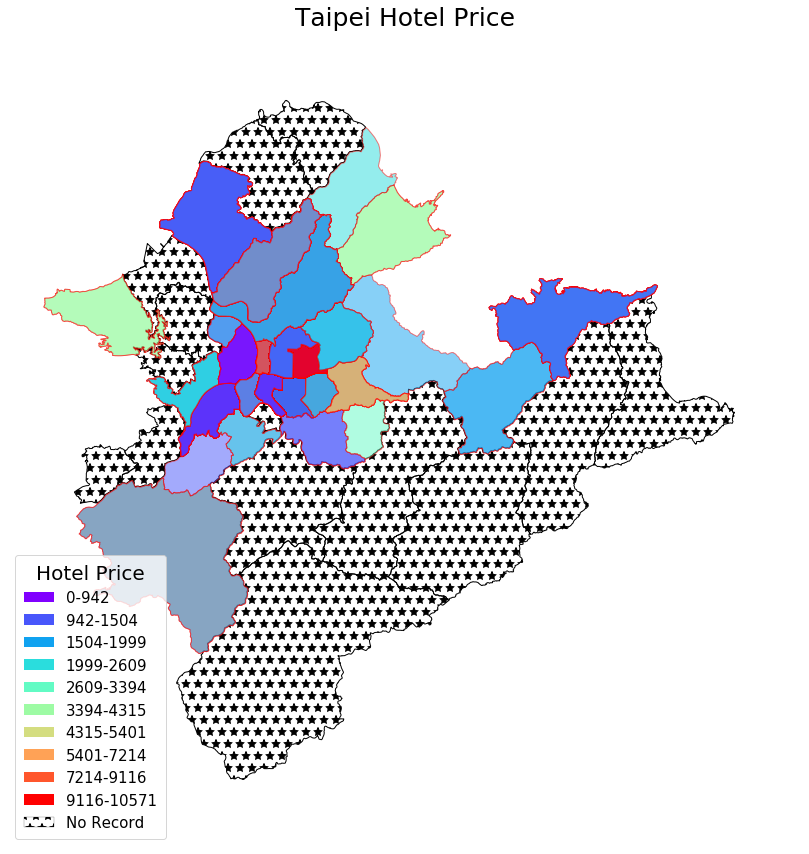

In [5]:
# 有價格紀錄的行政區，該行政區即便只有一家旅店，整個行政區也會有顏色分布
# 只有在沒旅店的行政區，才不會有顏色分布
# 這樣的做法會必較粗糙，較為精細的描繪方法可參考visualization_2.ipynb
ax = gplt.choropleth(df = poly_data.loc[poly_data['town with record']] ,
                     projection = gcrs.AlbersEqualArea() ,
                     hue = column ,
                     scheme = mc.FisherJenks(poly_data.query("{} != 0".format(column))[column]  , k = 10),
                     cmap = 'rainbow' ,
                     alpha = 0.5 ,
                     edgecolor = 'red' ,
                     linewidth = 1 ,
                     figsize = (15 , 15))

# 無價格紀錄的行政區，會在該行政區以'*'表示
ax = gplt.polyplot(df = poly_data.loc[~poly_data['town with record']] ,
                   projection = gcrs.AlbersEqualArea() ,
                   hatch = '*',
                   edgecolor = 'black',
                   ax = ax)

# 得到mapclassify中BoxPlot的數據分層點
bp = mc.FisherJenks(poly_data.loc[poly_data['town with record'] , column] , k = 10)
bins = [0] + bp.bins.tolist()
cmap = plt.get_cmap('rainbow')

# 製作圖例映射對象列表
LegendElement = [mpatches.Patch(facecolor = cmap(_ / (10-1)) ,
                                label = f'{int(bins[_])}-{int(bins[_+1])}')
                 for _ in range(0 , 10)] + \
                [mpatches.Patch(facecolor = 'none',
                                edgecolor = 'black',
                                linewidth = 0.2,
                                hatch = '*',
                                label = 'No Record')]

# 將制作好的圖例映射對象列表導入legend()中，並配置相關參數
ax.legend(handles = LegendElement ,
          loc = 'lower left',
          fontsize = 15,
          title = 'Hotel Price',
          title_fontsize = 20 ,
          borderpad = 0.6)
 
# 添加標題
plt.title('Taipei Hotel Price' , fontsize = 25)